## Stern-Gerlach Experiment

This notebook provides an example code of running famous Stern-Gerlach experiment in qiskit library. The electron spins are encoded in a qubit and the result of quantum measurment will collapse the wavefunction of qubit, reproducing the expected consequce of the famous thought experiment

In [1]:
# import Qiskit
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city

In [2]:
import numpy as np

In [3]:
my_token =''

In [4]:
#IBMQ provider
from qiskit import IBMQ
provider = IBMQ.enable_account(my_token)

In [5]:
#provider = IBMQ.get_provider(hub='ibm-q-skku', group='skku', project='saint')
device_backend = provider.get_backend('ibmq_5_yorktown')

In [6]:
# we will use statevector simulator for this exercise.
vector_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

Throughtout this exercise, we will use a qubit to simulate a spin-1/2 electron in the thought experiment. Instead of notation of + and -, we will use 1 and 0 respectively as representation, but it really doensn't change any physical meaning here.

We preapre single qubit state as $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$ as a source state. Measurement along Z can be done by qubit state measurement along computational basis (0 and 1), and Measurement along X can be done by qubit state measurement followed by corresponding basis rotation along Y axis. 


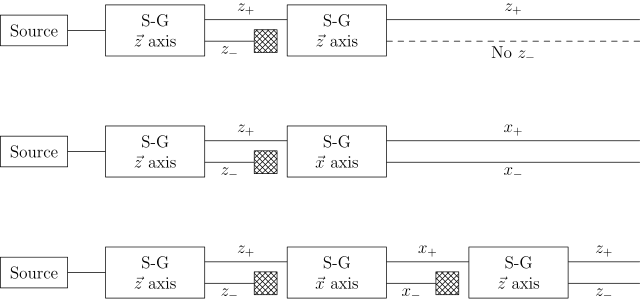  (image from wikipedia)

### 1. consecutive Z-axis measurement

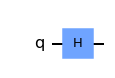

In [7]:
# apply hadamard gate to prepare + state
qc = QuantumCircuit(1)
qc.h(0) # initial state = + state
qc.draw()

$q_0$ is our qubit, physical quantum system which is simulating spin-1/2 electorns in Stern-Gerlach experiment. We will check the state vector of $q_0$ with `statevector_simulator`.

state vector is [0.70710678+0.j 0.70710678+0.j]


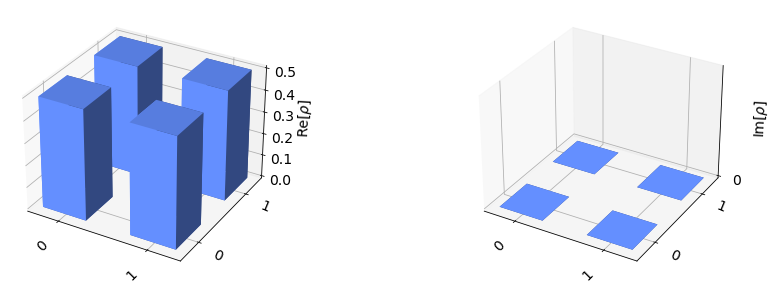

In [8]:
# let's see what is our state vector before measurement
result = execute(qc, vector_sim).result()
vector = result.get_statevector()
print(f'state vector is {vector}')
plot_state_city(vector)

One of postulates of quantum mechanics is about 'Quantum Measurement', which collapse the wavefunction (or the statevector) randomly with probabilites given by the state. Once wavefunction is collapsed, it becomes eigenstate of measured value.
Here, we have $|+\rangle$ as an initial state. If you measure the qubit state with respect to computational basis (z-axis), probabilities of finding 0 or 1 are the same, 0.5 for either cases. Eigenstates of measured value 0 and 1 are $|0\rangle$ and $|1\rangle$ respectively.

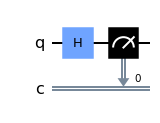

In [9]:
# add measurement along z axis
qc = QuantumCircuit(1,1)
qc.h(0) # initial state = + state
qc.measure(0, 0) # state measurement along z axis
qc.draw()

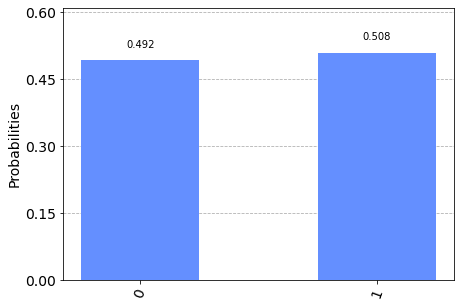

In [10]:
# Try qasm simulator first. We expect equal probabilty of 0 and 1.
result = execute(qc, qasm_sim).result()
plot_histogram(result.get_counts())

measured value is {'1': 1}
state vector is [0.+0.j 1.+0.j]


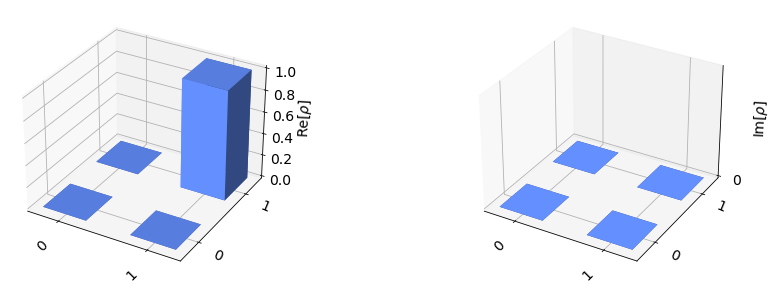

In [11]:
# How about state vector? Try this cell multiple times to see how it changes
result = execute(qc, vector_sim).result()
vector = result.get_statevector()
print(f'measured value is {result.get_counts()}')
print(f'state vector is {vector}')
plot_state_city(vector)

Let's reproduce the first experiment in the figure. We need consecutive two z-axis measurement, which simply measuring qubit state twice.

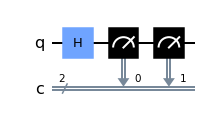

In [12]:
# two consecutive qubit state measurement
qc = QuantumCircuit(1,2)
qc.h(0) # initial state = + state
qc.measure(0, 0) # state measurement along z axis
qc.measure(0, 1) # state measurement along z axis
qc.draw()

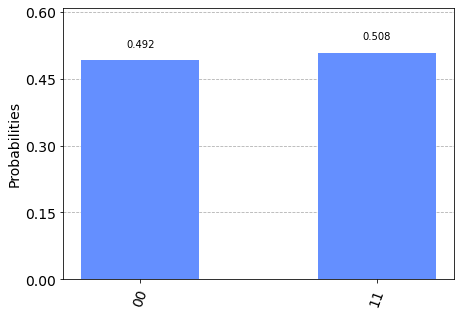

In [13]:
# qasm simualtor result
result = execute(qc, qasm_sim).result()
plot_histogram(result.get_counts())

It is not possible to block the states with $z_-$ or 0 with our quantum computer, but we can post select the cases based on the final result. You can see that the first measurement and the second measurement results are the same.

(Note that the first measurement is the last bit in the result.)

measured value is {'11': 1}
state vector is [0.+0.j 1.+0.j]


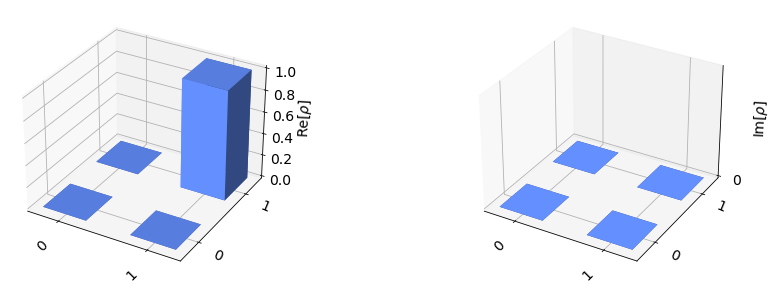

In [14]:
# How about state vector? Try this cell multiple times to see how it changes
result = execute(qc, vector_sim).result()
vector = result.get_statevector()
print(f'measured value is {result.get_counts()}')
print(f'state vector is {vector}')
plot_state_city(vector)

In [15]:
# let's run from the real device!
job = execute(qc, device_backend)

In [16]:
# check job status
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [17]:
# run this cell if job is done.
if job.in_final_state():
    result = job.result()
    plot_histogram(result.get_counts())
else:
    print('job is not done!')

job is not done!


## 2. Z - X measurement

Now, the second measurement is along x axis, which can be acomplished by state measurement followed by hadamard gate.

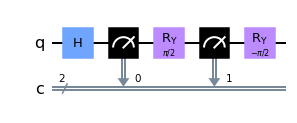

In [18]:
# two consecutive qubit state measurement
qc = QuantumCircuit(1,2)
qc.h(0) # initial state = + state
qc.measure(0, 0) # state measurement along z axis
# following three lines process state measurement along x axis
qc.ry(np.pi/2, 0)
qc.measure(0,1) 
qc.ry(-np.pi/2, 0)
qc.draw()

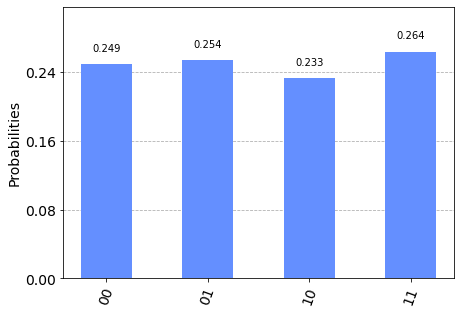

In [19]:
# qasm simualtor result
result = execute(qc, qasm_sim).result()
plot_histogram(result.get_counts())

Again, the first measurement result is the last bit in the result. so `10` means first z-axis measurement result is 0 ($z_-$) and the second x-axis measurement result is 1($x_+$). Let's group the result by the first measurement result.

In [20]:
counts = result.get_counts()
counts_minus = {key[0]: value for key, value in counts.items() if key[-1] == '0' }
counts_plus = {key[0]: value for key, value in counts.items() if key[-1] == '1' }

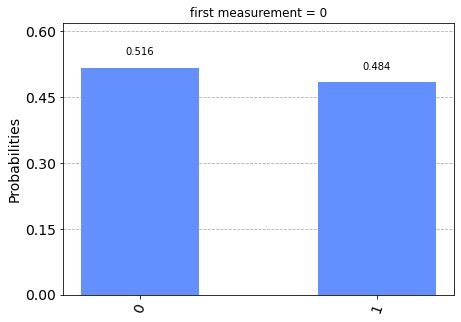

In [21]:
plot_histogram(counts_minus, title = 'first measurement = 0')

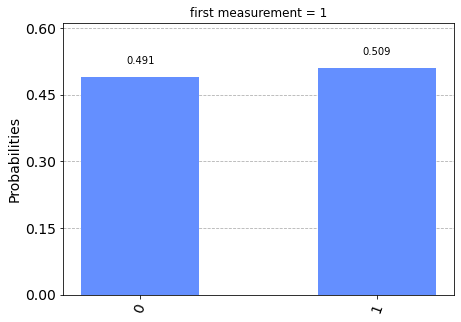

In [22]:
plot_histogram(counts_plus, title = 'first measurement = 1')

So, the probabilities of finding 1 and 0 eigienvalue along x-axis is the same each other. By adding up the probability, we can simply say finding x+ and x- is the same no matter what result was with the first measurement.

$P(x = 1) = P(x=1|z=0) P(z=0) + P(x=1|z=1)  P(z=1)$
$P(x = 0) = P(x=0|z=0) P(z=0) + P(x=0|z=1)  P(z=1)$

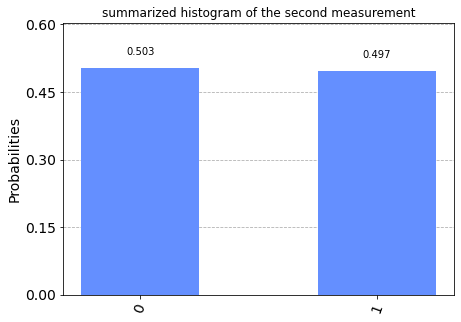

In [23]:
counts_sum = {key:(counts_minus[key]+counts_plus[key]) for key in counts_minus.keys()}
plot_histogram(counts_sum, title = 'summarized histogram of the second measurement')

What if we remove the first measurement? Let's try it.

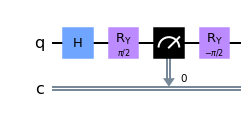

In [24]:
# two consecutive qubit state measurement
qc = QuantumCircuit(1,1)
qc.h(0) # initial state = + state
# following three lines process state measurement along x axis
qc.ry(np.pi/2, 0)
qc.measure(0,0) 
qc.ry(-np.pi/2, 0)
qc.draw()

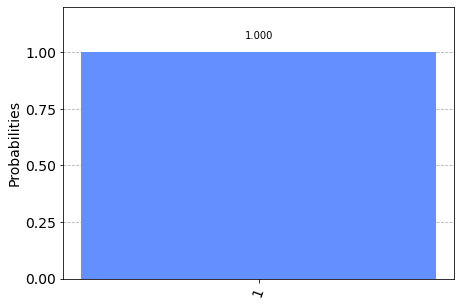

In [25]:
# qasm simualtor result
result = execute(qc, qasm_sim).result()
plot_histogram(result.get_counts())

How does it look? does it makes sense to you? If not, why?

## 3. Z-X-Z measurement

If you followed the all above, the third experiment will be pretty straightforward. Here's the circuit

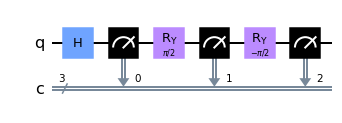

In [26]:
# three consecutive qubit state measurement
qc = QuantumCircuit(1,3)
qc.h(0) # initial state = + state
qc.measure(0, 0) # state measurement along z axis
# following three lines process state measurement along x axis
qc.ry(np.pi/2, 0)
qc.measure(0, 1) 
qc.ry(-np.pi/2, 0)

qc.measure(0, 2) # state measurement along z axis
qc.draw()

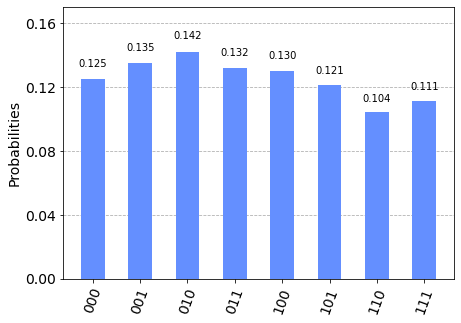

In [27]:
# qasm simualtor result
result = execute(qc, qasm_sim).result()
plot_histogram(result.get_counts())

We're going to post-select bitstrings ending with '11', which means the first and second measurement result was 1 or +, as like in the figure.

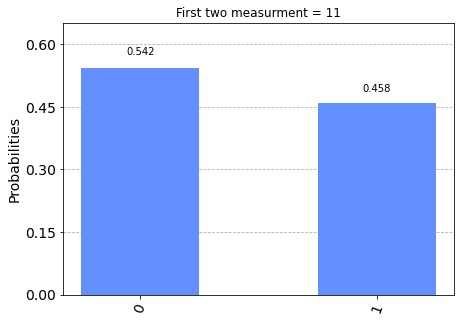

In [28]:
# post-select bitstrings ending with '11'
counts = result.get_counts()
counts_postselected = {key[0]: value for key, value in counts.items() if key[1:3] =='11'}
plot_histogram(counts_postselected, title = "First two measurment = 11")

So at the first measurment, we had 1. If you recall the result from experiment \#1, you would expect following measurement along z axis will be also 1. But by adding one more measurement along x between, we now have equal probability of having 0 and 1 as a result.

In [29]:
# run with real device
job = execute(qc, device_backend)

In [34]:
# check the job status
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [31]:
# run this cell if job is done.
if job.in_final_state():
    result = job.result()
    plot_histogram(result.get_counts())
else:
    print('job is not done!')

job is not done!


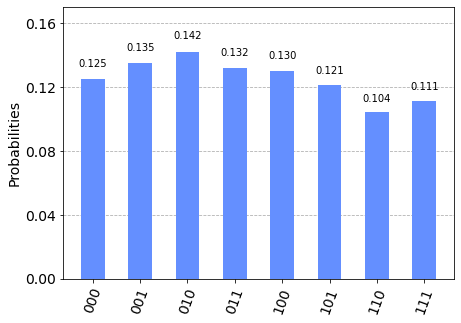

In [32]:
plot_histogram(result.get_counts())

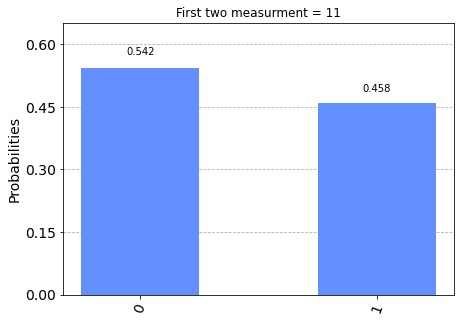

In [33]:
# post-select bitstrings ending with '11'
counts = result.get_counts()
counts_postselected = {key[0]: value for key, value in counts.items() if key[1:3] =='11'}
plot_histogram(counts_postselected, title = "First two measurment = 11")